In [1]:
import pandas as pd
import pickle 

# GET PARAMETERS
import os 
import sys
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_model_on_k_fold_validation import load_configuration

Training and Hyper-parameter tuning with Ray is not possible


/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load 'args' from a trial id

In [3]:
trial_id = 'subway_in_subway_out_calendar_STAEformer_MSELoss_2025_05_06_02_00_73032'


# 'subway_in_subway_out_calendar_STAEformer_MSELoss_2025_05_06_02_00_73032' # STAEformer + Stack Channel + 500 epochs
# ' subway_in_subway_out_calendar_STGformer_MSELoss_2025_05_03_04_19_34322' # STGformer w/o calendar + Stack Channel + 500 epochs
# 'subway_in_subway_out_ASTGCN_MSELoss_2025_04_21_20_06_76371 ' ASTGCN + Stack Channel + 500 epochs
# 'subway_in_subway_out_ASTGCN_MSELoss_2025_04_21_02_26_61597' ASTGCN + Stack Channel + 100 epochs
# 'subway_in_subway_out_STGCN_MSELoss_2025_02_20_22_43_85017' NEW RIM ARCHITECTURE : Stack Channel / No spatial Attn /
# 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271' NEW RIM ARCHITECTURE : Stack Channel / No spatial Attn / No Temporal Attn
# "subway_in_netmob_POIs_per_station_STGCN_MSELoss_2025_02_18_03_38_83510" # NEW RIM ARCHITECTURE
# 'subway_in_subway_out_STGCN_MSELoss_2025_02_14_16_03_71730' # NEW RIM ARCHITECTURE


# "subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_02_01_12_25_68609"   #  Bug ????

# "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963"
# 'subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_05_04_80480'
# "subway_in_STGCN_MSELoss_2025_01_06_08_00_94523"
args,_ = load_configuration(trial_id,load_config=True)

print('Best args: ')
print(args)


>>>> Load best CONFIG
Best args: 
Namespace(model_name='STAEformer', dataset_names=['subway_in', 'subway_out', 'calendar'], dataset_for_coverage=['subway_in', 'netmob_POIs'], calendar_types=['dayofweek', 'timeofday'], embedding_calendar_types=['dayofweek', 'hour'], device=device(type='cuda'), optimizer='adamw', single_station=False, loss_function_type='MSE', epsilon_clustering=0.05, freq='15min', minmaxnorm=True, standardize=False, learnable_adj_matrix=False, learnable_adj_top_k=8, learnable_adj_embd_dim=8, contextual_positions={'calendar_dayofweek': 0, 'calendar_timeofday': 1, 'subway_out': 2}, quick_vision=False, netmob_transfer_mode='DL', evaluate_complete_ds=True, train_valid_test_split_method='similar_length_method', set_spatial_units=None, hp_tuning_on_first_fold=True, keep_best_weights=False, num_workers=0, persistent_workers=False, pin_memory=True, prefetch_factor=2, drop_last=False, mixed_precision=True, non_blocking=True, torch_compile=False, backend='inductor', prefetch_all

Best configs:


,training_iteration,Loss_model,lr,weight_decay,dropout,input_embedding_dim,adaptive_embedding_dim,num_heads,num_layers,feed_forward_dim,use_mixed_proj,torch_scheduler_milestone,torch_scheduler_gamma,torch_scheduler_lr_start_factor
232,500,0.003942,0.00406,0.055260,0.103913,8,32,4,3,32,True,7,0.986538,0.604592
245,500,0.004050,0.00136,0.061312,0.043653,16,32,2,5,8,False,10,0.992713,0.368402
161,500,0.004073,0.00152,0.081419,0.121549,24,12,1,4,16,True,4,0.994398,0.274702
493,500,0.004103,0.00946,0.094140,0.139241,16,12,4,3,256,True,3,0.987031,0.358074
371,500,0.004120,0.00292,0.092190,0.111715,8,16,1,3,32,True,17,0.985703,0.632893
170,500,0.004163,0.00412,0.098645,0.070331,8,24,4,2,64,False,8,0.988269,0.444822
381,500,0.004171,0.00179,0.006035,0.051995,16,12,1,4,32,True,4,0.996387,0.475101
317,500,0.004172,0.00451,0.090812,0.046972,24,24,4,3,128,True,9,0.985840,0.834017
211,500,0.004172,0.00779,0.025628,0.065089,8,24,1,3,32,True,18,0.986142,0.522838
56,500,0.004174,0.00393,0.007624,0.035842,8,12,4,2,16,True,1,0.996000,0.589176


Best configs:


,training_iteration,Loss_model,lr,weight_decay,dropout,input_embedding_dim,adaptive_embedding_dim,num_heads,num_layers,feed_forward_dim,use_mixed_proj,torch_scheduler_milestone,torch_scheduler_gamma,torch_scheduler_lr_start_factor
374,500,0.004050,0.00912,0.059483,0.028975,8,12,2,2,64,True,2,0.997531,0.667365
459,500,0.004188,0.00134,0.079822,0.063833,24,64,2,3,8,True,12,0.995003,0.144547
448,500,0.004189,0.00434,0.035438,0.104766,16,24,2,3,64,True,2,0.990618,0.954879
415,500,0.004193,0.00752,0.077818,0.018957,8,12,2,3,8,True,7,0.990124,0.146308
472,500,0.004223,0.00465,0.025958,0.111145,24,32,4,4,8,True,15,0.985926,0.244631
382,500,0.004246,0.00702,0.090961,0.118092,24,64,4,1,16,True,3,0.997173,0.894055
313,500,0.004263,0.00807,0.021035,0.155836,8,32,4,4,128,True,6,0.997451,0.260160
237,500,0.004271,0.00332,0.004849,0.157044,16,12,4,4,16,True,1,0.994835,0.654857
114,500,0.004299,0.00371,0.005931,0.167335,8,24,4,2,16,False,11,0.986134,0.639621
164,500,0.004317,0.00857,0.091764,0.163388,8,24,4,4,64,True,6,0.996005,0.336012


Best configs:


,training_iteration,Loss_model,lr,weight_decay,dropout,input_embedding_dim,adaptive_embedding_dim,num_heads,num_layers,feed_forward_dim,use_mixed_proj,torch_scheduler_milestone,torch_scheduler_gamma,torch_scheduler_lr_start_factor
220,500,0.003952,0.00310,0.039820,0.191679,24,12,1,4,64,True,17,0.996678,0.990132
196,500,0.004003,0.00427,0.021138,0.115532,8,32,4,3,64,False,18,0.986955,0.637188
317,500,0.004025,0.00188,0.000643,0.100188,24,16,2,3,32,True,18,0.992318,0.895792
149,500,0.004064,0.00441,0.048441,0.080504,8,16,2,2,16,False,12,0.995750,0.766817
10,500,0.004083,0.00226,0.091479,0.118037,8,16,4,3,64,False,7,0.993264,0.337329
312,500,0.004107,0.00123,0.007396,0.147550,24,24,4,4,32,True,10,0.996469,0.211725
291,500,0.004113,0.00823,0.042067,0.195818,8,64,1,2,256,True,19,0.985787,0.172712
412,500,0.004128,0.00164,0.062049,0.139530,16,24,4,5,32,False,8,0.993027,0.805646
474,500,0.004140,0.00094,0.094578,0.031698,8,64,1,5,32,True,15,0.987380,0.284824
240,500,0.004146,0.00874,0.045794,0.185589,8,32,1,5,8,True,1,0.997529,0.212012


Best configs:


,training_iteration,Loss_model,lr,weight_decay,dropout,input_embedding_dim,adaptive_embedding_dim,num_heads,num_layers,feed_forward_dim,use_mixed_proj,torch_scheduler_milestone,torch_scheduler_gamma,torch_scheduler_lr_start_factor
34,500,0.004005,0.00140,0.079953,0.132423,8,24,4,3,8,True,2,0.996672,0.924369
362,500,0.004216,0.00770,0.083236,0.171825,8,24,2,4,8,True,8,0.989346,0.384673
361,500,0.004253,0.00960,0.041193,0.083712,8,8,2,2,16,True,1,0.990693,0.376012
150,500,0.004286,0.00101,0.058027,0.012201,8,64,4,4,16,False,2,0.992900,0.464057
65,500,0.004288,0.00281,0.033020,0.144286,24,16,4,4,8,True,8,0.992960,0.271754
414,500,0.004292,0.00603,0.050539,0.112241,16,12,1,4,32,True,17,0.995177,0.206782
433,500,0.004318,0.00850,0.080550,0.171861,16,64,4,4,256,True,6,0.986844,0.378679
13,500,0.004346,0.00682,0.032644,0.192838,16,8,4,2,32,True,6,0.991880,0.272039
328,500,0.004359,0.00205,0.048083,0.068529,16,64,4,3,16,True,15,0.988261,0.660049
85,500,0.004373,0.00222,0.068851,0.093445,8,32,2,2,256,False,15,0.992280,0.687251


Best configs:


,training_iteration,Loss_model,lr,weight_decay,dropout,input_embedding_dim,adaptive_embedding_dim,num_heads,num_layers,feed_forward_dim,use_mixed_proj,torch_scheduler_milestone,torch_scheduler_gamma,torch_scheduler_lr_start_factor
177,500,0.004129,0.00529,0.047101,0.166333,8,32,2,3,16,True,19,0.987621,0.638994
306,500,0.004168,0.00256,0.076267,0.074807,24,24,4,5,32,True,6,0.991493,0.560512
55,500,0.004171,0.00395,0.088258,0.064550,8,32,2,5,8,True,14,0.993724,0.939552
454,500,0.004206,0.00193,0.014810,0.106010,8,64,4,5,8,True,7,0.986051,0.412739
64,500,0.004226,0.00861,0.086249,0.007767,8,16,1,3,32,False,13,0.989225,0.420880
264,500,0.004279,0.00345,0.038327,0.199344,16,32,4,3,32,True,5,0.989867,0.314486
146,500,0.004281,0.00200,0.059695,0.171731,24,12,4,2,128,False,8,0.997769,0.156660
408,500,0.004285,0.00243,0.099899,0.052373,16,24,4,4,16,True,19,0.997062,0.752709
389,500,0.004317,0.00171,0.092148,0.063290,8,24,2,5,16,True,10,0.991676,0.261780
441,500,0.004350,0.00461,0.063823,0.193897,16,32,4,4,16,False,17,0.986245,0.233495


Best configs:


,training_iteration,Loss_model,lr,weight_decay,dropout,input_embedding_dim,adaptive_embedding_dim,num_heads,num_layers,feed_forward_dim,use_mixed_proj,torch_scheduler_milestone,torch_scheduler_gamma,torch_scheduler_lr_start_factor
410,500,0.004143,0.00207,0.090855,0.139134,8,24,4,3,64,False,9,0.997129,0.792562
275,500,0.004167,0.00279,0.062321,0.022407,8,16,2,4,8,True,4,0.996519,0.702908
340,500,0.004183,0.00778,0.065203,0.190121,16,32,1,4,8,True,16,0.993341,0.542869
27,500,0.004227,0.00211,0.067253,0.015668,16,12,4,5,8,True,19,0.993118,0.686012
30,500,0.004339,0.00516,0.075917,0.136562,8,64,4,3,8,False,9,0.988887,0.109869
259,500,0.004375,0.00941,0.088335,0.024526,8,16,4,3,64,True,7,0.991151,0.781488
117,500,0.004404,0.00287,0.088499,0.102888,16,24,2,4,128,True,3,0.986222,0.273881
311,500,0.004415,0.00534,0.059157,0.149486,16,24,1,1,16,False,14,0.989687,0.405437
144,500,0.004419,0.00381,0.024355,0.187078,8,12,2,1,32,False,7,0.990531,0.358197
426,500,0.004437,0.00258,0.051636,0.044467,24,8,2,3,8,True,8,0.995393,0.843579


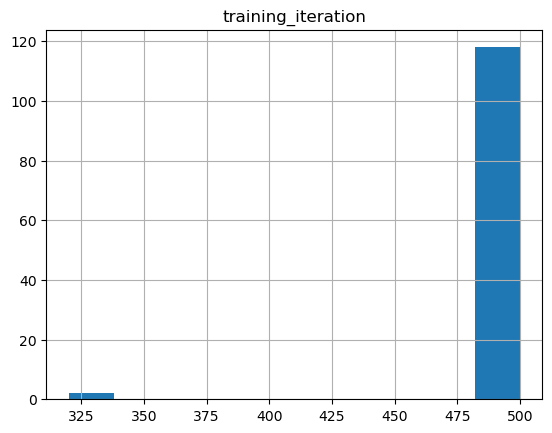

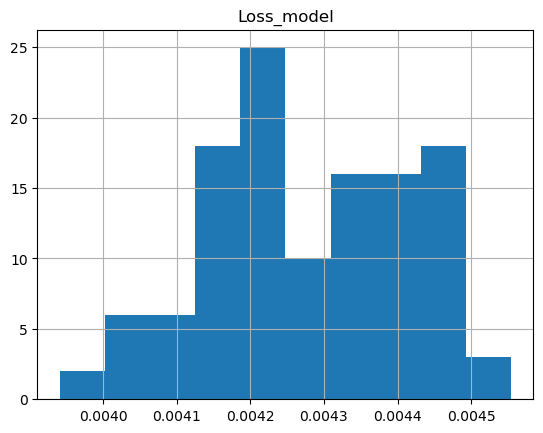

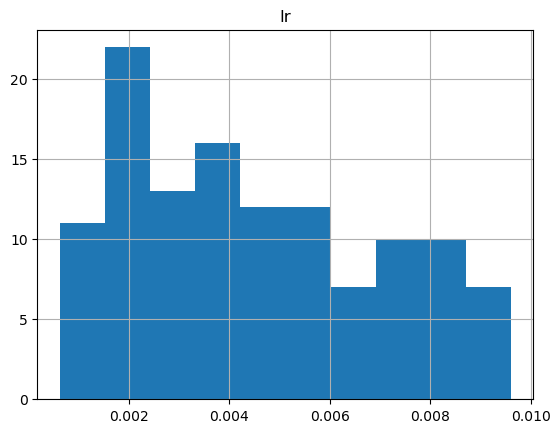

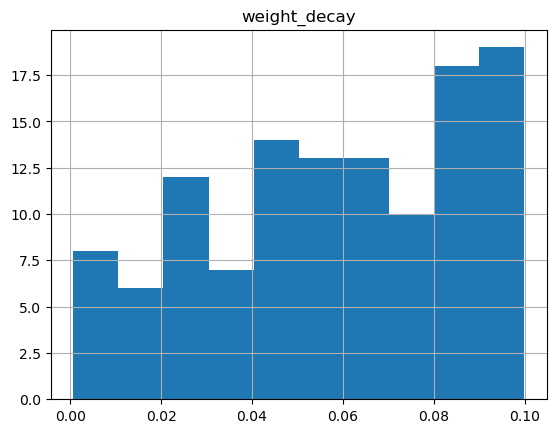

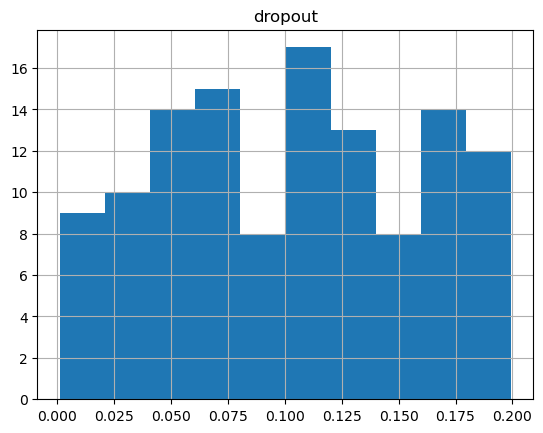

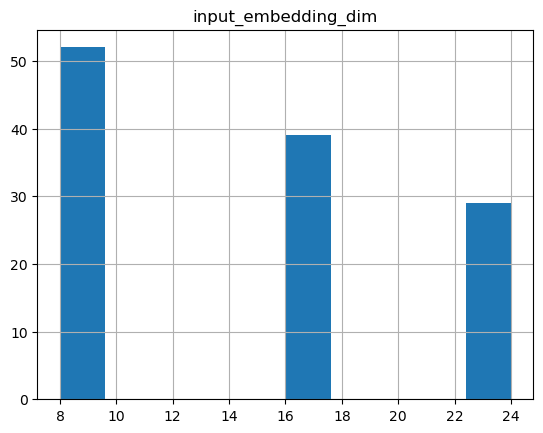

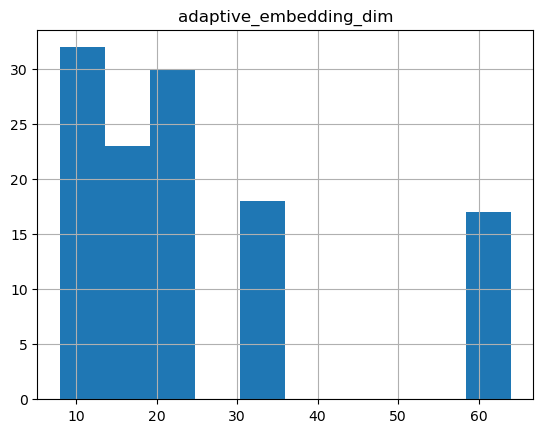

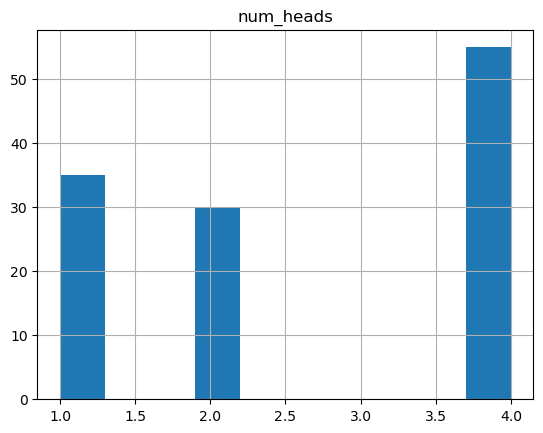

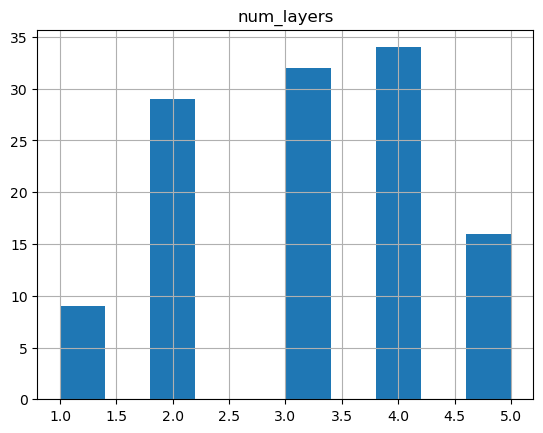

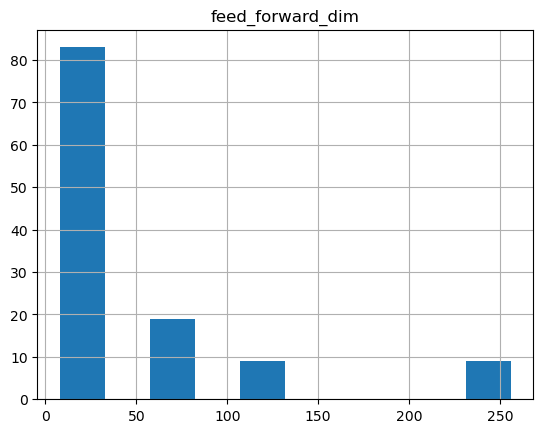

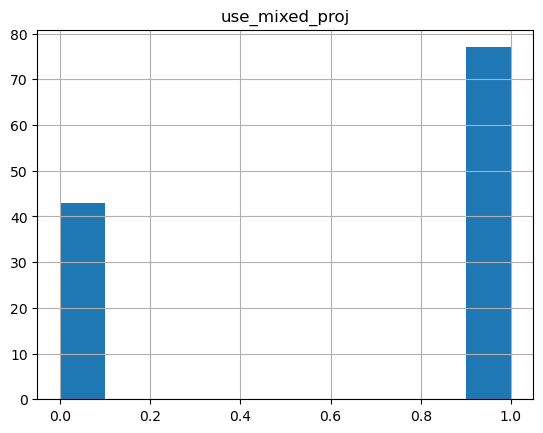

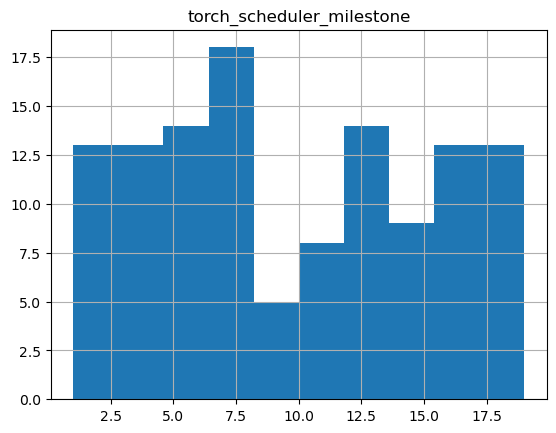

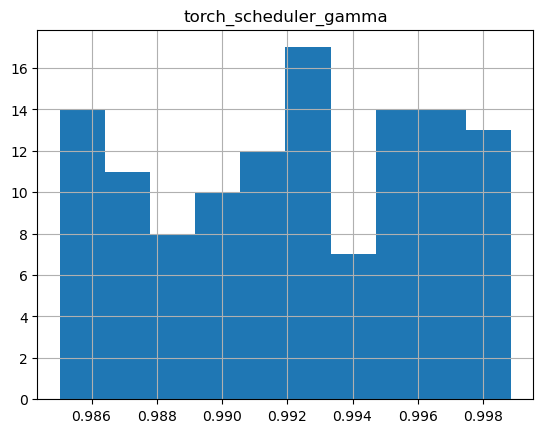

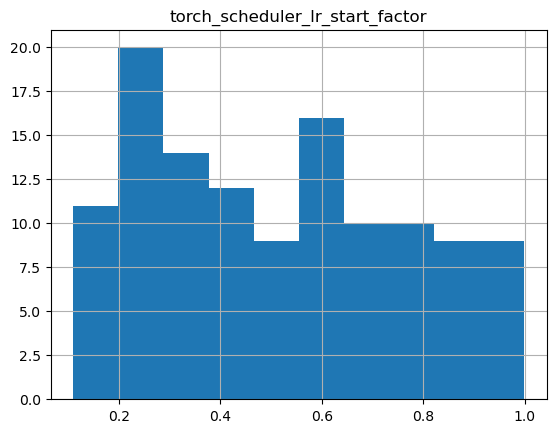

In [26]:
trial_id = 'subway_in_subway_out_calendar_STAEformer_MSELoss_2025_05_06_02_00_73032'

df_all = pd.DataFrame()

trial_ids = ['subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_09_19_28_36371',
'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_10_07_36_27059',
'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_10_19_28_4752',
'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_11_07_23_58546',
'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_11_17_51_55895',
'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_12_04_10_74908']

#trial_ids = ['subway_in_STGCN_MSELoss_2025_05_13_03_09_7326',
#'subway_in_calendar_embedding_STGCN_MSELoss_2025_05_13_22_43_80647'
#]
for trial_id in trial_ids:

# 'subway_in_subway_out_calendar_STAEformer_MSELoss_2025_05_06_02_00_73032' # STAEformer + Stack Channel + 500 epochs
# ' subway_in_subway_out_calendar_STGformer_MSELoss_2025_05_03_04_19_34322' # STGformer w/o calendar + Stack Channel + 500 epochs
# 'subway_in_subway_out_ASTGCN_MSELoss_2025_04_21_20_06_76371 ' ASTGCN + Stack Channel + 500 epochs
# 'subway_in_subway_out_ASTGCN_MSELoss_2025_04_21_02_26_61597' ASTGCN + Stack Channel + 100 epochs
# 'subway_in_subway_out_STGCN_MSELoss_2025_02_20_22_43_85017' NEW RIM ARCHITECTURE : Stack Channel / No spatial Attn /
# 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271' NEW RIM ARCHITECTURE : Stack Channel / No spatial Attn / No Temporal Attn
# "subway_in_netmob_POIs_per_station_STGCN_MSELoss_2025_02_18_03_38_83510" # NEW RIM ARCHITECTURE
# 'subway_in_subway_out_STGCN_MSELoss_2025_02_14_16_03_71730' # NEW RIM ARCHITECTURE

    df_hp_tuning =pd.read_csv(f'{parent_dir}/save/HyperparameterTuning/{trial_id}.csv')
    model_args = pickle.load(open(f'{parent_dir}/save/HyperparameterTuning/model_args.pkl','rb'))
    metric = '_metric/Loss_model'
    # Load common args through all tuning trials:
    args = model_args['model'][trial_id]['args']

    # Rename columns, remove useless ones: 
    columns = [c for c in df_hp_tuning.columns if ('_metric/' in c) or ('config/' in c) or ('training_iteration' in c)]
    columns_rename = {c:c.split('/')[-1] for c in columns}
    df_best_configs = df_hp_tuning[columns].sort_values(metric).rename(columns = columns_rename)
    df_best_configs
    print('Best configs:')
    display(df_best_configs.iloc[:20])

    df_all = pd.concat([df_all,df_best_configs.iloc[:20]])


import matplotlib.pyplot as plt
for c in df_all.columns:
    plt.title(c)
    df_all[c].astype(float).hist()
    plt.show()

Get the configuration: 

In [16]:
for c in df_best_configs.columns:
    v = df_best_configs.iloc[0,:][c]
    print(f"'{c}': {v}")

'training_iteration': 100
'Loss_model': 0.0031529362496546
'lr': 0.00105
'weight_decay': 0.0188896655584368
'dropout': 0.271795372610271
'Kt': 2
'stblock_num': 3
'gso_type': sym_renorm_adj
'temporal_h_dim': 256
'spatial_h_dim': 32
'output_h_dim': 16
'scheduler': True
'torch_scheduler_milestone': 28.0
'torch_scheduler_gamma': 0.9958348861339396
'torch_scheduler_lr_start_factor': 0.8809942312067847


In [ ]:
df = df_best_configs[~df_best_configs.scheduler.isna()]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['lr'], df['weight_decay'], df['dropout'], 
                     c=df['Loss_model'], cmap='YlOrRd_r', s=50)

ax.set_xlabel('lr')
ax.set_ylabel('weight_decay')
ax.set_zlabel('dropout')
ax.set_title("Loss function of weight-decay, dropout and lr")
ax.view_init(30, 60, 0)
fig.colorbar(scatter, ax=ax, label='Loss_model')
plt.show()

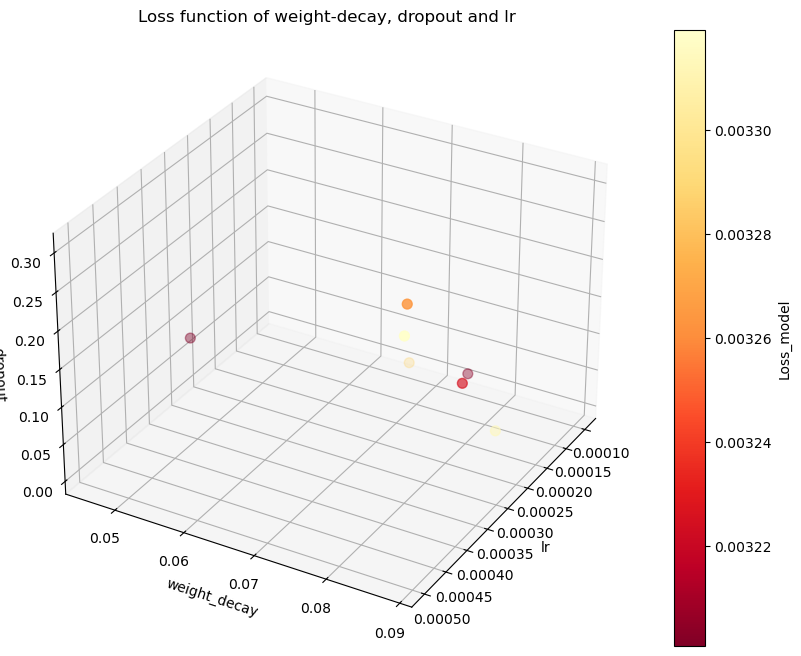

In [33]:


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plotting_loss_function_of_w_d_lr(df):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(df['lr'], df['weight_decay'], df['dropout'], 
                        c=df['Loss_model'], cmap='YlOrRd_r', s=50)

    ax.set_xlabel('lr')
    ax.set_ylabel('weight_decay')
    ax.set_zlabel('dropout')
    ax.set_title("Loss function of weight-decay, dropout and lr")
    ax.view_init(30, 30, 0)
    fig.colorbar(scatter, ax=ax, label='Loss_model')
    plt.show()


max_loss = 0.00332
max_lr =1 #0.003
df_filtered = df_best_configs[(df_best_configs['Loss_model'] < max_loss) &
                              (df_best_configs['lr'] < max_lr)]

df = df_filtered[~df_filtered.scheduler.isna()]
plotting_loss_function_of_w_d_lr(df)


#df = df_filtered[df_filtered.scheduler.isna()]
#plotting_loss_function_of_w_d_lr(df)


#plotting_loss_function_of_w_d_lr(df_filtered)

In [4]:
df_hp_tuning =pd.read_csv(f'save/HyperparameterTuning/{trial_id}.csv')
model_args = pickle.load(open(f'save/HyperparameterTuning/model_args.pkl','rb'))
metric = '_metric/Loss_model'
# Load common args through all tuning trials:
args = model_args['model'][trial_id]['args']

# Rename columns, remove useless ones: 
columns = [c for c in df_hp_tuning.columns if ('_metric/' in c) or ('config/' in c)]
columns_rename = {c:c.split('/')[-1] for c in columns}
df_best_configs = df_hp_tuning[columns].sort_values(metric).rename(columns = columns_rename)
df_best_configs
print('Best configs:')
display(df_best_configs.iloc[:20])

Best configs:


,Loss_model,lr,weight_decay,dropout,temporal_h_dim,spatial_h_dim,output_h_dim,TGE_num_layers,TGE_num_heads,TGE_FC_hdim,scheduler,torch_scheduler_milestone,torch_scheduler_gamma,torch_scheduler_lr_start_factor
43,0.003555,0.00145,0.093438,0.017829,128,32,64,3,1,8,True,29.0,0.988059,0.600637
180,0.003558,0.00290,0.056935,0.205239,8,128,32,8,2,16,True,16.0,0.994082,0.494039
415,0.003686,0.00310,0.076135,0.209686,128,32,16,4,1,64,True,6.0,0.989726,0.609100
479,0.003715,0.00260,0.015236,0.153810,64,16,256,8,8,16,True,21.0,0.986840,0.273233
72,0.003723,0.00265,0.056675,0.087503,64,128,64,1,1,8,True,13.0,0.987510,0.355194
488,0.003726,0.00030,0.035155,0.013960,32,32,256,1,1,256,NaN,NaN,NaN,NaN
234,0.003740,0.00060,0.082800,0.119636,32,256,256,2,8,16,True,14.0,0.991411,0.928782
262,0.003776,0.00125,0.061103,0.065937,16,64,32,3,8,64,True,13.0,0.989121,0.202832
247,0.003781,0.00245,0.054753,0.018427,32,128,8,4,1,64,NaN,NaN,NaN,NaN
57,0.003792,0.00015,0.068777,0.034193,128,8,256,8,2,256,True,6.0,0.996067,0.284229


## Load best configs from a trial id:

In [3]:
df_hp_tuning =pd.read_csv(f'save/HyperparameterTuning/{trial_id}.csv')
model_args = pickle.load(open(f'save/HyperparameterTuning/model_args.pkl','rb'))
metric = '_metric/Loss_model'
# Load common args through all tuning trials:
args = model_args['model'][trial_id]['args']

# Rename columns, remove useless ones: 
columns = [c for c in df_hp_tuning.columns if ('_metric/' in c) or ('config/' in c)]
columns_rename = {c:c.split('/')[-1] for c in columns}
df_best_configs = df_hp_tuning[columns].sort_values(metric).rename(columns = columns_rename)
df_best_configs
print('Best configs:')
display(df_best_configs.iloc[:20])

Best configs:


,Loss_model,lr,weight_decay,dropout,temporal_h_dim,spatial_h_dim,output_h_dim,scheduler,torch_scheduler_milestone,torch_scheduler_gamma,torch_scheduler_lr_start_factor,concatenation_early,concatenation_late,num_heads,grn_out_dim
351,0.005105,0.00065,0.007052,0.278061,256,256,8,True,25.0,0.991593,0.752912,True,False,2,64
226,0.005124,0.00115,0.065237,0.159976,16,8,8,NaN,NaN,NaN,NaN,True,True,4,32
414,0.005195,0.00055,0.024583,0.134271,32,256,16,NaN,NaN,NaN,NaN,True,True,4,16
316,0.005217,0.00110,0.022065,0.100491,256,64,32,True,28.0,0.995704,0.542937,True,True,1,16
353,0.005256,0.00400,0.072955,0.068490,32,8,8,NaN,NaN,NaN,NaN,True,False,3,24
358,0.005258,0.00260,0.017781,0.522119,16,8,256,NaN,NaN,NaN,NaN,True,False,1,8
255,0.005270,0.00055,0.065677,0.287299,256,256,128,NaN,NaN,NaN,NaN,True,False,2,8
272,0.005285,0.00485,0.015913,0.078816,64,64,256,True,2.0,0.998806,0.508260,True,False,2,32
286,0.005343,0.00070,0.033701,0.385530,256,64,128,True,7.0,0.990168,0.132749,True,True,6,48
341,0.005344,0.00390,0.037983,0.313570,128,16,32,NaN,NaN,NaN,NaN,True,True,3,24


## Load `the` best config, with no rename: 

In [8]:
# Get best config :
best_model = df_hp_tuning.sort_values(metric).iloc[0]
print('raw config of best model: ')
display(best_model)

raw config of best model: 


trial_id                                                                                       b9f67_00351
time_this_iter_s                                                                                  4.243078
done                                                                                                  True
training_iteration                                                                                     100
date                                                                                   2025-01-07_01-20-56
timestamp                                                                                       1736209256
time_total_s                                                                                    442.195914
pid                                                                                                 144430
hostname                                                                                 ticil2.ifsttar.fr
node_ip                              